# Run this cell first!

# Simple ring parameter constraints

This notebook provides test cases for the precision of a simple lens model (with simplified assumptions). This is for show-casing and to assess the uncertainty limit in how well the parameters of this model can be constrained.


In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline



# Parameters to play around with

In [2]:
#see what happens to the light travel time if you change to the mass. Choose a number between 0.01 and 2
mass_multiplier = 1.3

# coordinates of the lens
center_x = 0.001
center_y = 0.001

# coordinates of the source
source_x = 0
source_y = 0

# how bright is the source
source_brightness = 0.2

## simulation choices

In [3]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size per axis
pixel_scale = 0.05  #  pixel size in arcsec (area per pixel = pixel_scale**2)
fwhm = 0.05  # full width at half maximum of PSF
psf_type = 'NONE'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': .66* mass_multiplier, 'center_x': center_x, 'center_y': center_y, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)

# galaxy light
kwargs_sersic_lens = {'amp': 16*source_brightness, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}

lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)


In [4]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'NONE', 'fwhm': fwhm, 'pixel_size': pixel_scale, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class,
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

# Plot the image

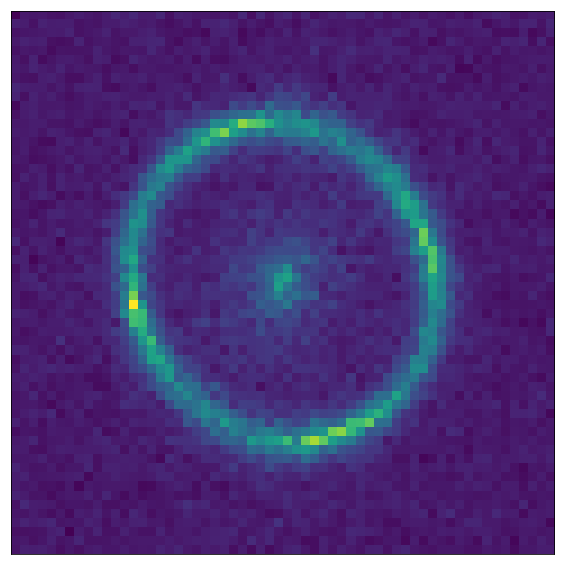

In [5]:
# display the initial simulated image
f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

ax = axes
im = ax.matshow(image_real, origin='lower', vmin= image_real.min(), vmax=image_real.max())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()